<div align="center"> 
    <br>
    <br>
    <img src="https://raw.githubusercontent.com/AI-team-UoA/pyJedAI/main/documentation/pyjedai.logo.drawio.png?raw=true" alt="drawing" width="400"/>
    <br>
    <hr>
    <font size="3">Dirty Entity Resolution Tutorial</font>
    <br>
</div>
<hr>

In this notebook we present the pyJedAI approach in the well-known ABT-BUY dataset. Dirty ER, is the process of dedeplication of one set.

# Instalation

pyJedAI is an open-source library that can be installed from PyPI.

For more: [pypi.org/project/pyjedai/](https://pypi.org/project/pyjedai/)

In [1]:
!pip install pyjedai -U

In [2]:
!pip show pyjedai

Name: pyjedai
Version: 0.0.4
Summary: An open-source library that builds powerful end-to-end Entity Resolution workflows.
Home-page: 
Author: 
Author-email: Konstantinos Nikoletos <nikoletos.kon@gmail.com>, George Papadakis <gpapadis84@gmail.com>
License: Apache Software License 2.0
Location: c:\users\nikol\anaconda3\envs\pyjedai391\lib\site-packages
Requires: faiss-cpu, gensim, matplotlib, matplotlib-inline, networkx, nltk, numpy, optuna, pandas, pandas-profiling, pandocfilters, PyYAML, rdflib, rdfpandas, regex, scipy, seaborn, sentence-transformers, strsim, strsimpy, tomli, tqdm, transformers
Required-by: 


Imports

In [3]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph

from pyjedai.utils import print_clusters, print_blocks, print_candidate_pairs
from pyjedai.evaluation import Evaluation

# Reading the dataset - Dirty ER example

pyJedAI in order to perfrom needs only the tranformation of the initial data into a pandas DataFrame. Hence, pyJedAI can function in every structured or semi-structured data. In this case Abt-Buy dataset is provided as .csv files. 

<div align="center">
    <img align="center" src="https://github.com/AI-team-UoA/pyJedAI/blob/main/documentation/reading-process.png?raw=true" width="800" />
</div>


## pyjedai <Data\> module

Data module offers a numpber of options
- Selecting the parameters (columns) of the dataframe, in D1 (and in D2)
- Prints a detailed text analysis
- Stores a hidden mapping of the ids, and creates it if not exists.

In [4]:
from pyjedai.datamodel import Data

d1 = pd.read_csv("./../data/cora/cora.csv", sep='|')
gt = pd.read_csv("./../data/cora/cora_gt.csv", sep='|', header=None)
attr = ['Entity Id','author', 'title']

Data is the connecting module of all steps of the workflow

In [5]:
data = Data(
    dataset_1=d1,
    id_column_name_1='Entity Id',
    ground_truth=gt,
    attributes_1=attr
)

data.process()

# Workflow with Block Cleaning Methods

In this notebook we created the bellow architecture:

![workflow1-cora.png](https://github.com/AI-team-UoA/pyJedAI/blob/main/documentation/workflow1-cora.png?raw=true)



## Block Building

It clusters entities into overlapping blocks in a lazy manner that relies on unsupervised blocking keys: every token in an attribute value forms a key. Blocks are then extracted, possibly using a transformation, based on its equality or on its similarity with other keys.

The following methods are currently supported:

- Standard/Token Blocking
- Sorted Neighborhood
- Extended Sorted Neighborhood
- Q-Grams Blocking
- Extended Q-Grams Blocking
- Suffix Arrays Blocking
- Extended Suffix Arrays Blocking

In [6]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
    ExtendedQGramsBlocking
)

In [7]:
blocks = SuffixArraysBlocking(
    suffix_length=2
).build_blocks(data)

Suffix Arrays Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [8]:
Evaluation(data).report(blocks)

#  Evaluation 
---
Scores:
	Precision:      4.28% 
	Recall:        75.77%
	F1-score:       8.10%
Classification report:
	True positives: 13021
	False positives: 291336
	True negatives: 542366
	False negatives: 4163
	Total comparisons: 304357
---


## Block Cleaning

___Optional step___

Its goal is to clean a set of overlapping blocks from unnecessary comparisons, which can be either redundant (i.e., repeated comparisons that have already been executed in a previously examined block) or superfluous (i.e., comparisons that involve non-matching entities). Its methods operate on the coarse level of individual blocks or entities.

In [9]:
from pyjedai.block_cleaning import BlockFiltering

In [10]:
filtered_blocks = BlockFiltering(
    ratio=0.9
).process(blocks, data)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
Evaluation(data).report(filtered_blocks)

#  Evaluation 
---
Scores:
	Precision:      5.10% 
	Recall:        73.46%
	F1-score:       9.53%
Classification report:
	True positives: 12623
	False positives: 235070
	True negatives: 598234
	False negatives: 4561
	Total comparisons: 247693
---


## Comparison Cleaning

___Optional step___

Similar to Block Cleaning, this step aims to clean a set of blocks from both redundant and superfluous comparisons. Unlike Block Cleaning, its methods operate on the finer granularity of individual comparisons.

The following methods are currently supported:

- Comparison Propagation
- Cardinality Edge Pruning (CEP)
- Cardinality Node Pruning (CNP)
- Weighed Edge Pruning (WEP)
- Weighed Node Pruning (WNP)
- Reciprocal Cardinality Node Pruning (ReCNP)
- Reciprocal Weighed Node Pruning (ReWNP)
- BLAST

Most of these methods are Meta-blocking techniques. All methods are optional, but competive, in the sense that only one of them can part of an ER workflow. For more details on the functionality of these methods, see here. They can be combined with one of the following weighting schemes:

- Aggregate Reciprocal Comparisons Scheme (ARCS)
- Common Blocks Scheme (CBS)
- Enhanced Common Blocks Scheme (ECBS)
- Jaccard Scheme (JS)
- Enhanced Jaccard Scheme (EJS)

In [12]:
from pyjedai.block_cleaning import BlockPurging

In [13]:
cleaned_blocks = BlockPurging(
    smoothing_factor=0.008
).process(blocks, data)

Block Purging:   0%|          | 0/3420 [00:00<?, ?it/s]

In [14]:
Evaluation(data).report(cleaned_blocks)

#  Evaluation 
---
Scores:
	Precision:      7.67% 
	Recall:         0.59%
	F1-score:       1.09%
Classification report:
	True positives: 101
	False positives: 1215
	True negatives: 819567
	False negatives: 17083
	Total comparisons: 1316
---


### Meta Blocking

In [15]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    # ReciprocalCardinalityWeightPruning,
    ComparisonPropagation
)

In [16]:
candidate_pairs_blocks = WeightedEdgePruning(
    weighting_scheme='CBS'
).process(filtered_blocks, data)

Weighted Edge Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [17]:
Evaluation(data).report(candidate_pairs_blocks)

#  Evaluation 
---
Scores:
	Precision:     74.46% 
	Recall:        48.51%
	F1-score:      58.75%
Classification report:
	True positives: 8336
	False positives: 2860
	True negatives: 826157
	False negatives: 8848
	Total comparisons: 11196
---


## Entity Matching

It compares pairs of entity profiles, associating every pair with a similarity in [0,1]. Its output comprises the similarity graph, i.e., an undirected, weighted graph where the nodes correspond to entities and the edges connect pairs of compared entities.

In [18]:
from pyjedai.matching import EntityMatching

In [19]:
attr = ['author', 'title']
# or with weights
attr = {
    'author' : 0.6,
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard', 
    similarity_threshold=0.5
)

pairs_graph = EM.predict(filtered_blocks, data)

Entity Matching (jaccard):   0%|          | 0/1684 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
attr = {
    'author' : 0.6, 
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard',
    similarity_threshold=0.5
)

pairs_graph = EM.predict(candidate_pairs_blocks, data)

Entity Matching (jaccard):   0%|          | 0/1294 [00:00<?, ?it/s]

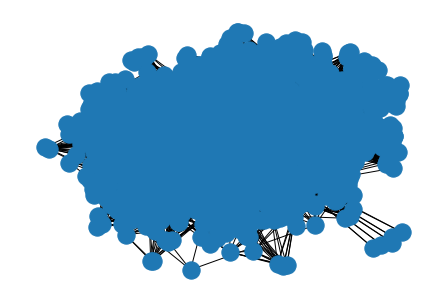

In [25]:
draw(pairs_graph)

In [26]:
e = Evaluation(data)
e.report(pairs_graph)

#  Evaluation 
---
Scores:
	Precision:      5.44% 
	Recall:         6.30%
	F1-score:       5.84%
Classification report:
	True positives: 1083
	False positives: 18819
	True negatives: 802945
	False negatives: 16101
	Total comparisons: 19902
---


## Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [21]:
from pyjedai.clustering import ConnectedComponentsClustering

In [22]:
clusters = ConnectedComponentsClustering().process(pairs_graph)

In [23]:
e = Evaluation(data)
e.report(pairs_graph)

#  Evaluation 
---
Scores:
	Precision:      5.44% 
	Recall:         6.30%
	F1-score:       5.84%
Classification report:
	True positives: 1083
	False positives: 18819
	True negatives: 802945
	False negatives: 16101
	Total comparisons: 19902
---


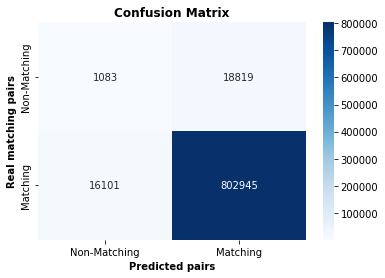

In [24]:
e.confusion_matrix()

# Workflow with Similarity Joins

In this notebook we created the bellow archtecture:

![workflow2-cora.png](https://github.com/AI-team-UoA/pyJedAI/blob/main/documentation/workflow2-cora.png?raw=true)



## Data Reading

Data is the connecting module of all steps of the workflow

In [25]:
from pyjedai.datamodel import Data
d1 = pd.read_csv("./../data/cora/cora.csv", sep='|')
gt = pd.read_csv("./../data/cora/cora_gt.csv", sep='|', header=None)
attr = ['Entity Id','author', 'title']
data = Data(
    dataset_1=d1,
    id_column_name_1='Entity Id',
    ground_truth=gt,
    attributes_1=attr
)

data.process()

## Similarity Joins

In [26]:
from pyjedai.joins import SchemaAgnosticΕJoin, TopKSchemaAgnosticJoin

In [27]:
g = SchemaAgnosticΕJoin(
    threshold = 0.5,
    metric = 'jaccard',
    tokenization = 'qgrams_multiset',
    qgrams = 2
).fit(data)

Schema Agnostic Join (jaccard):   0%|          | 0/2590 [00:00<?, ?it/s]

In [28]:
e = Evaluation(data)
e.report(g)

#  Evaluation 
---
Scores:
	Precision:     65.80% 
	Recall:        93.03%
	F1-score:      77.08%
Classification report:
	True positives: 15987
	False positives: 8311
	True negatives: 828357
	False negatives: 1197
	Total comparisons: 24298
---


In [29]:
g = TopKSchemaAgnosticJoin(
    K=20,
    metric = 'jaccard',
    tokenization = 'qgrams',
    qgrams = 3
).fit(data)

Top-K Schema Agnostic Join (jaccard):   0%|          | 0/2590 [00:00<?, ?it/s]

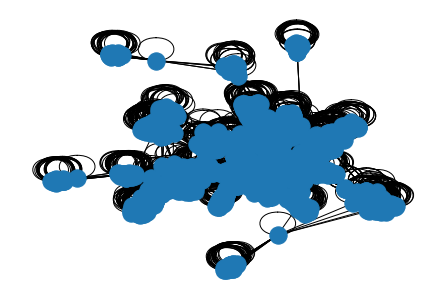

In [30]:
draw(g)

In [31]:
e = Evaluation(data)
e.report(g)

#  Evaluation 
---
Scores:
	Precision:     58.34% 
	Recall:        63.75%
	F1-score:      60.92%
Classification report:
	True positives: 10954
	False positives: 7822
	True negatives: 823813
	False negatives: 6230
	Total comparisons: 18776
---


## Entity Clustering

In [32]:
from pyjedai.clustering import ConnectedComponentsClustering

In [33]:
clusters = ConnectedComponentsClustering().process(g)

In [34]:
e = Evaluation(data)
e.report(clusters)

#  Evaluation 
---
Scores:
	Precision:      2.05% 
	Recall:       100.00%
	F1-score:       4.02%
Classification report:
	True positives: 17184
	False positives: 820681
	True negatives: 17184
	False negatives: 0
	Total comparisons: 837865
---


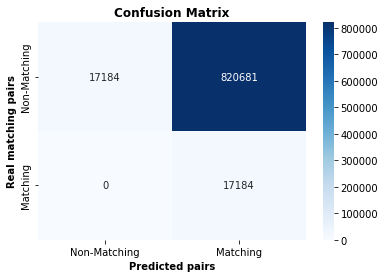

In [35]:
e.confusion_matrix()

<hr>
<div align="right">
K. Nikoletos, G. Papadakis & M. Koubarakis
</div>
<div align="right">
<a href="https://github.com/Nikoletos-K/pyJedAI/blob/main/LICENSE">Apache License 2.0</a>
</div>